# CS470 Introduction to Artificial Intelligence
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## 4. Recurrent Neural Networks
### 4-2.  Word embeddings
To handle the text data, we should convert the text into numbers first (i.e., preprocess the data). 

#### One-hot encodings 
First method for representing the text as numbers is an "one-hot" encode each word in the vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the number of the vocabularies, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

![One Hot Encodings](https://github.com/keai-kaist/CS470/blob/main/Lab3/May%2011/images/one-hot.png?raw=true)

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

However, This approach has several downsides. 
1. One-hot encoding is very inefficient. 
- A one-hot encoded vector is sparse (meaning most indicies are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.
2. One-hot encoding cannot incorporate semantics between each word.
- Every token in one-hot encoding is equally distant away from all the others. That is,

![One-hot distance](https://github.com/keai-kaist/CS470/blob/main/Lab3/May%2011/images/one-hot-distance.PNG?raw=true)


#### Word embeddings
Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand.

Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). So, the neural network captures the token's meaning as a vector.  
It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

![Word Embeddings](https://github.com/keai-kaist/CS470/blob/main/Lab3/May%2011/images/embeddings.png?raw=true)

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

- Papers related to word-embeddings
1. CBoW, Skip-gram: https://arxiv.org/pdf/1301.3781v3.pdf
2. GloVe: https://www.aclweb.org/anthology/D14-1162.pdf
3. fastText: https://arxiv.org/pdf/1607.04606v2.pdf

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import matplotlib.pyplot as plt

#### Using the Embedding Layer

![Keras embedding layer](https://github.com/keai-kaist/CS470/blob/main/Lab3/May%2011/images/keras-embedding.jpg?raw=true)

Keras makes it easy to use word embeddings. Let's take a look at the [`tf.keras.layers.Embedding(input_dim, output_dim)`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Embedding). This layers turns positive integers (indicies) into dense vectors of fixed size.
- `input_dim`: Size of the vocabulary. 2D tensor with shape `(batch_size, input_length)`
- `output_dim`: Dimension of the dense embedding. 3D tensor with shape `(batch_size, input_length, output_dim)`

---------이부분 설명해야함------

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors. The dimensionality of the embedding is a parameter you can experiment with to see what works well for your problem (much in the same way you would experiment with the number of neurons in a Dense layer).

When you create an Embedding layer, the weights for the embedding are randomly initialized. During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

---------이부분 설명해야함------

#### Learning embeddings from scratch
We will train a sentiment classifier on IMDB movie reviews we previously did. In the process, we will learn embeddings from scratch. 

In [2]:
vocab_size = 10000
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

As imported, the text of reviews is integer-encoded (each integer represents a specific word in a dictionary).

In [3]:
print(f'Length of data: {len(train_data[0])}')
print(train_data[0])
print(train_labels[0])

Length of data: 218
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [4]:
import numpy as np

embedding = tf.keras.layers.Embedding(10000, 16)
embedding(np.array([1,2,3,4,1,2]))

<tf.Tensor: shape=(6, 16), dtype=float32, numpy=
array([[ 0.02847464,  0.03780273,  0.01132794,  0.00671985,  0.00908358,
        -0.00487753,  0.03881743,  0.03115806, -0.01414986,  0.01264632,
        -0.00229532,  0.04276622,  0.01395691,  0.0174806 , -0.04956384,
        -0.01207414],
       [ 0.03977457,  0.03784201, -0.01015686,  0.03131368, -0.01304567,
        -0.0166531 , -0.00348819, -0.02567102, -0.001109  ,  0.01773306,
         0.01040789, -0.03389682,  0.00568116, -0.00654359, -0.01006129,
        -0.01836001],
       [-0.04675616,  0.04097727,  0.02617447, -0.01722314, -0.02310731,
        -0.04488571,  0.01311258, -0.01117438, -0.02425354,  0.03478792,
         0.00830635,  0.00342504, -0.0197068 , -0.01432742,  0.03596782,
         0.02582819],
       [-0.03699143, -0.02420338,  0.0456467 ,  0.00618888,  0.01072108,
         0.00681623, -0.02930198,  0.03318087,  0.04815615, -0.01437119,
        -0.01848196,  0.03485743, -0.01619468, -0.01302711, -0.0029523 ,
         

#### Convert the integers back to words
It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping.

And actually, by the default setting of [`tf.keras.datasets.imdb.load_data`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data), integer index 1 indicates the start of a sequence and 2 indicates the out-of-vocabulary character. Then, 4 is the first index that actual words appears.

#### Things to do

1. First, we will load imdb dictionary (word_int_dict) that maps words to an integer index
2. We will make a dictionary that maps integer index to words (int_word_dict, which is inverse of word_int_dict)
3. The actual words must appear from index 4 in int_word_dict
4. We will define some indexes for special tokens (0-PAD, 1-START, 2-UNK, 3-UNUSED)
5. Finally, we will define a function (decode_review) that can convert index array to sequence of words

In [5]:
word_int_dict = imdb.get_word_index()

In [6]:
int_word_dict = {}

for key in word_int_dict.keys():
    value = word_int_dict[key]
    int_word_dict[value+3] = key

int_word_dict[0] = "<PAD>"
int_word_dict[1] = "<START>"
int_word_dict[2] = "<UNK>"
int_word_dict[3] = "<UNUSED>"

def decode_review(text):
    ret=""
    for index in text:
        ret += int_word_dict[index]+' '
    return ret

In [7]:
min(list(int_word_dict.keys()))

0

In [9]:
int_word_dict[4]

'the'

In [10]:

print("Train_data[0]: {}\n".format(train_data[0]))
decode_review(train_data[0])

Train_data[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]



"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

Movie reviews can be different lengths. We will use the [`pad_sequences`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function to standardize the lengths of the reviews.

In [11]:
# Standardize the lenghts of data to use it as an input of model
maxlen = 500

# Return the 2D Numpy array of shape (train_data, maxlen) 
# by transfoming the input data with zeros peddings 
train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data,
    value=0,
    padding='post',
    maxlen=maxlen
)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=0,
    padding='post',
    maxlen=maxlen
)

In [12]:
print(f'Length of data: {len(train_data[0])}')
print(train_data[0])

Length of data: 500
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224  

#### Create simple embedding model 

Let's define our model using `tf.keras.Sequential`
- The first layer is a `tf.keras.layers.Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index (convert integers to floating values). These vectors are learned as the model trains.
- Next, a `tf.keras.layers.GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.  
![Global average pool 1D](https://github.com/keai-kaist/CS470/blob/main/Lab3/May%2011/images/global-average-pool-1d.png?raw=true)
- This fixed-length output vector is piped through a `tf.keras.layers.Dense` with 16 hidden units.
- The last layer is a `tf.keras.layers.Dense` with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [13]:
pooling_func = tf.keras.layers.GlobalAveragePooling1D()
result = pooling_func(
    np.array([
        [
         [1,4,5],
         [3,6,7]
         ]              
    ])

)

In [14]:
result

<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 5, 6]])>

In [15]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#### Compile and train the model 

In [17]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=512,
    validation_data = (test_data, test_labels)

)

Epoch 1/30
49/49 [==============================] - 3s 46ms/step - loss: 0.6919 - accuracy: 0.5630 - val_loss: 0.6896 - val_accuracy: 0.6940
Epoch 2/30
49/49 [==============================] - 2s 35ms/step - loss: 0.6827 - accuracy: 0.6763 - val_loss: 0.6745 - val_accuracy: 0.7229
Epoch 3/30
49/49 [==============================] - 2s 33ms/step - loss: 0.6568 - accuracy: 0.7545 - val_loss: 0.6403 - val_accuracy: 0.7624
Epoch 4/30
49/49 [==============================] - 2s 37ms/step - loss: 0.6090 - accuracy: 0.7798 - val_loss: 0.5884 - val_accuracy: 0.7885
Epoch 5/30
49/49 [==============================] - 2s 43ms/step - loss: 0.5471 - accuracy: 0.8168 - val_loss: 0.5297 - val_accuracy: 0.8166
Epoch 6/30
49/49 [==============================] - 2s 31ms/step - loss: 0.4829 - accuracy: 0.8432 - val_loss: 0.4744 - val_accuracy: 0.8342
Epoch 7/30
49/49 [==============================] - 2s 38ms/step - loss: 0.4264 - accuracy: 0.8632 - val_loss: 0.4292 - val_accuracy: 0.8464
Epoch 8/30
49

With this approach our model reaches a validation accuracy of around 88%.

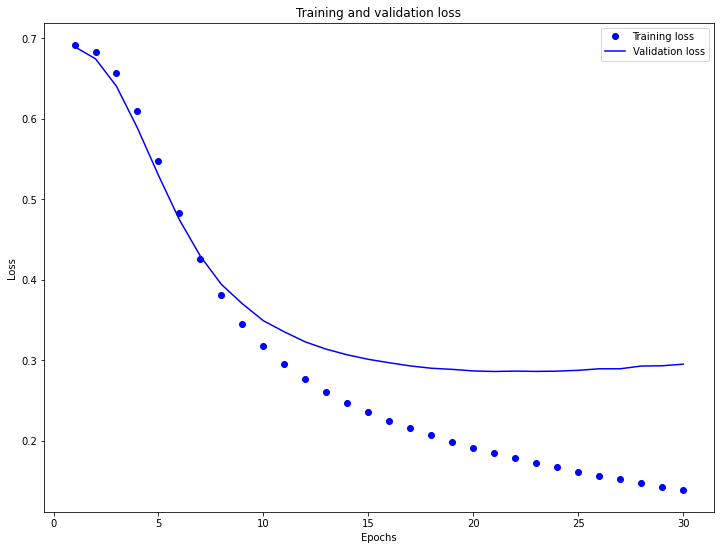

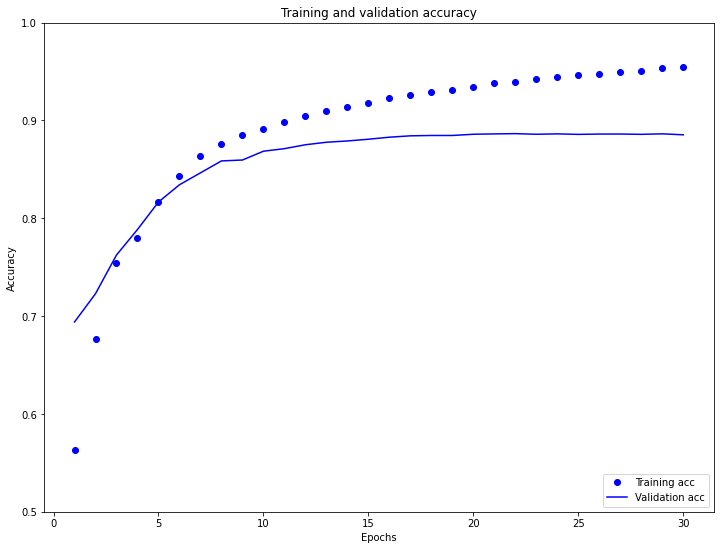

In [18]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5, 1))
plt.show()

#### Explore the learned embeddings
Next, let's explore the word embeddings learned during training. To use Embedding Projector, we will dump the embedding layers as two files: 
- A file of embeddings
- A file of meta data containing words

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

with open('embeddings.tsv', 'w', encoding='utf-8') as embeddings_file:
    with open('meta.tsv', 'w', encoding='utf-8') as meta_file:
        for word_index in range(vocab_size):
            word = int_word_dict[word_index]
            embedding = weights[word_index]
            
            print('\t'.join(str(x) for x in embedding), file=embeddings_file)
            print(word, file=meta_file)

In [20]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('embeddings.tsv')
    files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Then, we can visualize the embeddings using the [Embedding Projector](http://projector.tensorflow.org).

Once you load dumped files, the embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". (Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer)